In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
%load_ext autoreload
%autoreload 2

Set up training data

In the next cell, we set up the training data for this example. We’ll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
filename = "/Users/litz/Documents/GitHub/learning_GPyTorch/df.csv"
df = pd.read_csv(filename, index_col=None, header=0)
df

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,frac_age,ms_age,effective_T,log_g,radius,star_feh,delta_nu_fit,nu_max,hrgradient,fagegradient
0,0,1,1.05,0.28,0.0,2.1,0.089514,1.025962,5.701476,6020.401864,4.487184,0.968160,0.998265,145.333042,3401.690893,0.000197,0.002016
1,1,1,1.05,0.28,0.0,2.1,0.102056,1.029653,5.701476,6021.004397,4.486433,0.968998,0.997933,145.148810,3395.642769,0.000204,0.002420
2,2,1,1.05,0.28,0.0,2.1,0.117105,1.034099,5.701476,6021.569058,4.485608,0.969919,0.997538,144.946449,3389.036269,0.000219,0.002904
3,3,1,1.05,0.28,0.0,2.1,0.135165,1.039460,5.701476,6022.148049,4.484698,0.970936,0.997065,144.723391,3381.780702,0.000240,0.003484
4,4,1,1.05,0.28,0.0,2.1,0.156836,1.045930,5.701476,6022.769456,4.483688,0.972065,0.996500,144.476115,3373.756599,0.000267,0.004181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19440,19440,2,0.98,0.28,0.0,2.1,10.370700,9.975236,7.729887,4991.771740,3.614765,2.549161,0.990766,32.780509,501.142795,0.000530,0.000237
19441,19441,2,0.98,0.28,0.0,2.1,10.374359,9.983335,7.729887,4990.137910,3.610087,2.562915,0.990908,32.509757,495.854066,0.000545,0.000235
19442,19442,2,0.98,0.28,0.0,2.1,10.376164,9.987332,7.729887,4989.380370,3.607805,2.569650,0.991016,32.381770,493.292949,0.000529,0.000232
19443,19443,2,0.98,0.28,0.0,2.1,10.379737,9.995249,7.729887,4987.917756,3.603286,2.583039,0.991272,32.125098,488.258024,0.000585,0.000254


In [3]:
masses = np.unique(df.initial_mass)

mm = 1.10

dfu = df[df.initial_mass == 1.10]

True

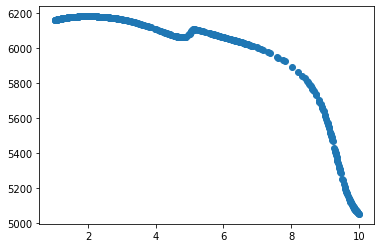

In [4]:
train_x = torch.tensor(list(dfu["frac_age"]))
train_y = torch.tensor(list((dfu["effective_T"])))
plt.scatter(train_x, train_y)
torch.is_tensor(train_x)
torch.is_tensor(train_y)

Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide the tools necessary to quickly construct one. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.
A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.
A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)
A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).
A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.
The GP Model

The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

An __init__ method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model’s forward method. This will most commonly include things like a mean module and a kernel module.
A forward method that takes in some 𝑛×𝑑 data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. In other words, we return the vector 𝜇(𝑥) and the 𝑛×𝑛 matrix 𝐾𝑥𝑥 representing the prior mean and covariance matrix of the GP.
This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())

Or you can add the outputs of the kernel in the forward method:

covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)

In [12]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Model modes

Like most PyTorch modules, the ExactGP has a .train() and .eval() mode. - .train() mode is for optimizing model hyperameters. - .eval() mode is for computing predictions through the model posterior.

Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

Zero all parameter gradients
Call the model and compute the loss
Call backward on the loss to fill in gradients
Take a step on the optimizer
However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [21]:
def model_run(step = None):
    # this is for running the notebook in our testing framework
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else step


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter): 
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    return

Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

The gpytorch.settings.fast_pred_var context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using LOVE.

Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The confidence_region method is a helper method that returns 2 standard deviations above and below the mean.

In [ ]:
model_run(step = 5000)

Iter 1/5000 - Loss: 209.532   lengthscale: 11.509   noise: 196.129
Iter 2/5000 - Loss: 209.426   lengthscale: 11.409   noise: 196.229
Iter 3/5000 - Loss: 209.304   lengthscale: 11.479   noise: 196.329
Iter 4/5000 - Loss: 209.191   lengthscale: 11.547   noise: 196.429
Iter 5/5000 - Loss: 209.080   lengthscale: 11.573   noise: 196.529
Iter 6/5000 - Loss: 208.964   lengthscale: 11.563   noise: 196.629
Iter 7/5000 - Loss: 208.848   lengthscale: 11.532   noise: 196.729
Iter 8/5000 - Loss: 208.733   lengthscale: 11.496   noise: 196.829
Iter 9/5000 - Loss: 208.621   lengthscale: 11.466   noise: 196.929
Iter 10/5000 - Loss: 208.509   lengthscale: 11.452   noise: 197.028
Iter 11/5000 - Loss: 208.395   lengthscale: 11.455   noise: 197.128
Iter 12/5000 - Loss: 208.281   lengthscale: 11.472   noise: 197.228
Iter 13/5000 - Loss: 208.167   lengthscale: 11.496   noise: 197.328
Iter 14/5000 - Loss: 208.054   lengthscale: 11.518   noise: 197.428
Iter 15/5000 - Loss: 207.942   lengthscale: 11.534   nois

Iter 145/5000 - Loss: 194.592   lengthscale: 11.486   noise: 210.144
Iter 146/5000 - Loss: 194.498   lengthscale: 11.486   noise: 210.238
Iter 147/5000 - Loss: 194.405   lengthscale: 11.486   noise: 210.332
Iter 148/5000 - Loss: 194.312   lengthscale: 11.486   noise: 210.426
Iter 149/5000 - Loss: 194.219   lengthscale: 11.486   noise: 210.520
Iter 150/5000 - Loss: 194.126   lengthscale: 11.486   noise: 210.614
Iter 151/5000 - Loss: 194.034   lengthscale: 11.486   noise: 210.708
Iter 152/5000 - Loss: 193.941   lengthscale: 11.486   noise: 210.802
Iter 153/5000 - Loss: 193.848   lengthscale: 11.486   noise: 210.896
Iter 154/5000 - Loss: 193.756   lengthscale: 11.485   noise: 210.990
Iter 155/5000 - Loss: 193.664   lengthscale: 11.485   noise: 211.084
Iter 156/5000 - Loss: 193.572   lengthscale: 11.485   noise: 211.177
Iter 157/5000 - Loss: 193.480   lengthscale: 11.485   noise: 211.271
Iter 158/5000 - Loss: 193.388   lengthscale: 11.485   noise: 211.365
Iter 159/5000 - Loss: 193.296   le

Iter 284/5000 - Loss: 182.717   lengthscale: 11.471   noise: 222.862
Iter 285/5000 - Loss: 182.638   lengthscale: 11.471   noise: 222.951
Iter 286/5000 - Loss: 182.560   lengthscale: 11.471   noise: 223.040
Iter 287/5000 - Loss: 182.482   lengthscale: 11.471   noise: 223.129
Iter 288/5000 - Loss: 182.404   lengthscale: 11.471   noise: 223.217
Iter 289/5000 - Loss: 182.327   lengthscale: 11.471   noise: 223.306
Iter 290/5000 - Loss: 182.249   lengthscale: 11.471   noise: 223.395
Iter 291/5000 - Loss: 182.171   lengthscale: 11.471   noise: 223.484
Iter 292/5000 - Loss: 182.094   lengthscale: 11.470   noise: 223.573
Iter 293/5000 - Loss: 182.016   lengthscale: 11.470   noise: 223.661
Iter 294/5000 - Loss: 181.939   lengthscale: 11.470   noise: 223.750
Iter 295/5000 - Loss: 181.862   lengthscale: 11.470   noise: 223.839
Iter 296/5000 - Loss: 181.785   lengthscale: 11.470   noise: 223.927
Iter 297/5000 - Loss: 181.707   lengthscale: 11.470   noise: 224.016
Iter 298/5000 - Loss: 181.630   le

Iter 420/5000 - Loss: 172.868   lengthscale: 11.457   noise: 234.680
Iter 421/5000 - Loss: 172.801   lengthscale: 11.457   noise: 234.765
Iter 422/5000 - Loss: 172.734   lengthscale: 11.457   noise: 234.850
Iter 423/5000 - Loss: 172.667   lengthscale: 11.457   noise: 234.935
Iter 424/5000 - Loss: 172.600   lengthscale: 11.457   noise: 235.020
Iter 425/5000 - Loss: 172.533   lengthscale: 11.457   noise: 235.104
Iter 426/5000 - Loss: 172.466   lengthscale: 11.456   noise: 235.189
Iter 427/5000 - Loss: 172.400   lengthscale: 11.456   noise: 235.274
Iter 428/5000 - Loss: 172.333   lengthscale: 11.456   noise: 235.359
Iter 429/5000 - Loss: 172.267   lengthscale: 11.456   noise: 235.443
Iter 430/5000 - Loss: 172.200   lengthscale: 11.456   noise: 235.528
Iter 431/5000 - Loss: 172.134   lengthscale: 11.456   noise: 235.613
Iter 432/5000 - Loss: 172.068   lengthscale: 11.456   noise: 235.697
Iter 433/5000 - Loss: 172.001   lengthscale: 11.456   noise: 235.782
Iter 434/5000 - Loss: 171.935   le

Iter 561/5000 - Loss: 164.056   lengthscale: 11.443   noise: 246.401
Iter 562/5000 - Loss: 163.998   lengthscale: 11.442   noise: 246.483
Iter 563/5000 - Loss: 163.939   lengthscale: 11.442   noise: 246.564
Iter 564/5000 - Loss: 163.881   lengthscale: 11.442   noise: 246.645
Iter 565/5000 - Loss: 163.823   lengthscale: 11.442   noise: 246.727
Iter 566/5000 - Loss: 163.765   lengthscale: 11.442   noise: 246.808
Iter 567/5000 - Loss: 163.707   lengthscale: 11.442   noise: 246.889
Iter 568/5000 - Loss: 163.649   lengthscale: 11.442   noise: 246.971
Iter 569/5000 - Loss: 163.591   lengthscale: 11.442   noise: 247.052
Iter 570/5000 - Loss: 163.534   lengthscale: 11.442   noise: 247.133
Iter 571/5000 - Loss: 163.476   lengthscale: 11.442   noise: 247.215
Iter 572/5000 - Loss: 163.418   lengthscale: 11.441   noise: 247.296
Iter 573/5000 - Loss: 163.361   lengthscale: 11.441   noise: 247.377
Iter 574/5000 - Loss: 163.303   lengthscale: 11.441   noise: 247.458
Iter 575/5000 - Loss: 163.246   le

Iter 691/5000 - Loss: 156.918   lengthscale: 11.430   noise: 256.810
Iter 692/5000 - Loss: 156.867   lengthscale: 11.429   noise: 256.889
Iter 693/5000 - Loss: 156.815   lengthscale: 11.429   noise: 256.967
Iter 694/5000 - Loss: 156.763   lengthscale: 11.429   noise: 257.046
Iter 695/5000 - Loss: 156.712   lengthscale: 11.429   noise: 257.125
Iter 696/5000 - Loss: 156.660   lengthscale: 11.429   noise: 257.204
Iter 697/5000 - Loss: 156.609   lengthscale: 11.429   noise: 257.282
Iter 698/5000 - Loss: 156.557   lengthscale: 11.429   noise: 257.361
Iter 699/5000 - Loss: 156.506   lengthscale: 11.429   noise: 257.439
Iter 700/5000 - Loss: 156.454   lengthscale: 11.429   noise: 257.518
Iter 701/5000 - Loss: 156.403   lengthscale: 11.429   noise: 257.597
Iter 702/5000 - Loss: 156.352   lengthscale: 11.428   noise: 257.675
Iter 703/5000 - Loss: 156.300   lengthscale: 11.428   noise: 257.754
Iter 704/5000 - Loss: 156.249   lengthscale: 11.428   noise: 257.832
Iter 705/5000 - Loss: 156.198   le

Iter 816/5000 - Loss: 150.775   lengthscale: 11.417   noise: 266.515
Iter 817/5000 - Loss: 150.728   lengthscale: 11.417   noise: 266.592
Iter 818/5000 - Loss: 150.682   lengthscale: 11.417   noise: 266.668
Iter 819/5000 - Loss: 150.635   lengthscale: 11.417   noise: 266.745
Iter 820/5000 - Loss: 150.588   lengthscale: 11.417   noise: 266.821
Iter 821/5000 - Loss: 150.542   lengthscale: 11.417   noise: 266.898
Iter 822/5000 - Loss: 150.495   lengthscale: 11.417   noise: 266.974
Iter 823/5000 - Loss: 150.449   lengthscale: 11.417   noise: 267.051
Iter 824/5000 - Loss: 150.403   lengthscale: 11.416   noise: 267.127
Iter 825/5000 - Loss: 150.356   lengthscale: 11.416   noise: 267.204
Iter 826/5000 - Loss: 150.310   lengthscale: 11.416   noise: 267.280
Iter 827/5000 - Loss: 150.264   lengthscale: 11.416   noise: 267.356
Iter 828/5000 - Loss: 150.217   lengthscale: 11.416   noise: 267.433
Iter 829/5000 - Loss: 150.171   lengthscale: 11.416   noise: 267.509
Iter 830/5000 - Loss: 150.125   le

Iter 949/5000 - Loss: 144.875   lengthscale: 11.404   noise: 276.563
Iter 950/5000 - Loss: 144.833   lengthscale: 11.404   noise: 276.638
Iter 951/5000 - Loss: 144.791   lengthscale: 11.404   noise: 276.712
Iter 952/5000 - Loss: 144.749   lengthscale: 11.404   noise: 276.787
Iter 953/5000 - Loss: 144.707   lengthscale: 11.404   noise: 276.861
Iter 954/5000 - Loss: 144.665   lengthscale: 11.404   noise: 276.936
Iter 955/5000 - Loss: 144.623   lengthscale: 11.404   noise: 277.010
Iter 956/5000 - Loss: 144.581   lengthscale: 11.404   noise: 277.085
Iter 957/5000 - Loss: 144.539   lengthscale: 11.404   noise: 277.159
Iter 958/5000 - Loss: 144.497   lengthscale: 11.403   noise: 277.234
Iter 959/5000 - Loss: 144.455   lengthscale: 11.403   noise: 277.308
Iter 960/5000 - Loss: 144.413   lengthscale: 11.403   noise: 277.383
Iter 961/5000 - Loss: 144.372   lengthscale: 11.403   noise: 277.457
Iter 962/5000 - Loss: 144.330   lengthscale: 11.403   noise: 277.531
Iter 963/5000 - Loss: 144.288   le

Iter 1078/5000 - Loss: 139.679   lengthscale: 11.392   noise: 286.074
Iter 1079/5000 - Loss: 139.640   lengthscale: 11.392   noise: 286.147
Iter 1080/5000 - Loss: 139.602   lengthscale: 11.392   noise: 286.220
Iter 1081/5000 - Loss: 139.563   lengthscale: 11.392   noise: 286.293
Iter 1082/5000 - Loss: 139.525   lengthscale: 11.391   noise: 286.365
Iter 1083/5000 - Loss: 139.487   lengthscale: 11.391   noise: 286.438
Iter 1084/5000 - Loss: 139.448   lengthscale: 11.391   noise: 286.511
Iter 1085/5000 - Loss: 139.410   lengthscale: 11.391   noise: 286.584
Iter 1086/5000 - Loss: 139.372   lengthscale: 11.391   noise: 286.657
Iter 1087/5000 - Loss: 139.333   lengthscale: 11.391   noise: 286.730
Iter 1088/5000 - Loss: 139.295   lengthscale: 11.391   noise: 286.802
Iter 1089/5000 - Loss: 139.257   lengthscale: 11.391   noise: 286.875
Iter 1090/5000 - Loss: 139.219   lengthscale: 11.391   noise: 286.948
Iter 1091/5000 - Loss: 139.180   lengthscale: 11.391   noise: 287.021
Iter 1092/5000 - Los

Iter 1199/5000 - Loss: 135.203   lengthscale: 11.380   noise: 294.813
Iter 1200/5000 - Loss: 135.167   lengthscale: 11.380   noise: 294.885
Iter 1201/5000 - Loss: 135.132   lengthscale: 11.380   noise: 294.957
Iter 1202/5000 - Loss: 135.096   lengthscale: 11.380   noise: 295.028
Iter 1203/5000 - Loss: 135.061   lengthscale: 11.380   noise: 295.100
Iter 1204/5000 - Loss: 135.025   lengthscale: 11.380   noise: 295.171
Iter 1205/5000 - Loss: 134.990   lengthscale: 11.380   noise: 295.243
Iter 1206/5000 - Loss: 134.954   lengthscale: 11.380   noise: 295.314
Iter 1207/5000 - Loss: 134.919   lengthscale: 11.380   noise: 295.386
Iter 1208/5000 - Loss: 134.884   lengthscale: 11.380   noise: 295.457
Iter 1209/5000 - Loss: 134.848   lengthscale: 11.379   noise: 295.529
Iter 1210/5000 - Loss: 134.813   lengthscale: 11.379   noise: 295.600
Iter 1211/5000 - Loss: 134.778   lengthscale: 11.379   noise: 295.672
Iter 1212/5000 - Loss: 134.742   lengthscale: 11.379   noise: 295.743
Iter 1213/5000 - Los

Iter 1318/5000 - Loss: 131.125   lengthscale: 11.369   noise: 303.260
Iter 1319/5000 - Loss: 131.092   lengthscale: 11.369   noise: 303.330
Iter 1320/5000 - Loss: 131.059   lengthscale: 11.369   noise: 303.401
Iter 1321/5000 - Loss: 131.026   lengthscale: 11.369   noise: 303.471
Iter 1322/5000 - Loss: 130.993   lengthscale: 11.369   noise: 303.542
Iter 1323/5000 - Loss: 130.960   lengthscale: 11.369   noise: 303.612
Iter 1324/5000 - Loss: 130.927   lengthscale: 11.369   noise: 303.682
Iter 1325/5000 - Loss: 130.894   lengthscale: 11.368   noise: 303.753
Iter 1326/5000 - Loss: 130.861   lengthscale: 11.368   noise: 303.823
Iter 1327/5000 - Loss: 130.828   lengthscale: 11.368   noise: 303.893
Iter 1328/5000 - Loss: 130.795   lengthscale: 11.368   noise: 303.964
Iter 1329/5000 - Loss: 130.762   lengthscale: 11.368   noise: 304.034
Iter 1330/5000 - Loss: 130.730   lengthscale: 11.368   noise: 304.104
Iter 1331/5000 - Loss: 130.697   lengthscale: 11.368   noise: 304.175
Iter 1332/5000 - Los

Iter 1443/5000 - Loss: 127.142   lengthscale: 11.357   noise: 311.994
Iter 1444/5000 - Loss: 127.112   lengthscale: 11.357   noise: 312.063
Iter 1445/5000 - Loss: 127.081   lengthscale: 11.357   noise: 312.133
Iter 1446/5000 - Loss: 127.050   lengthscale: 11.357   noise: 312.202
Iter 1447/5000 - Loss: 127.020   lengthscale: 11.357   noise: 312.271
Iter 1448/5000 - Loss: 126.989   lengthscale: 11.357   noise: 312.341
Iter 1449/5000 - Loss: 126.958   lengthscale: 11.357   noise: 312.410
Iter 1450/5000 - Loss: 126.928   lengthscale: 11.357   noise: 312.479
Iter 1451/5000 - Loss: 126.897   lengthscale: 11.357   noise: 312.549
Iter 1452/5000 - Loss: 126.866   lengthscale: 11.357   noise: 312.618
Iter 1453/5000 - Loss: 126.836   lengthscale: 11.356   noise: 312.687
Iter 1454/5000 - Loss: 126.805   lengthscale: 11.356   noise: 312.756
Iter 1455/5000 - Loss: 126.775   lengthscale: 11.356   noise: 312.826
Iter 1456/5000 - Loss: 126.744   lengthscale: 11.356   noise: 312.895
Iter 1457/5000 - Los

Iter 1571/5000 - Loss: 123.345   lengthscale: 11.345   noise: 320.810
Iter 1572/5000 - Loss: 123.316   lengthscale: 11.345   noise: 320.878
Iter 1573/5000 - Loss: 123.287   lengthscale: 11.345   noise: 320.947
Iter 1574/5000 - Loss: 123.259   lengthscale: 11.345   noise: 321.015
Iter 1575/5000 - Loss: 123.230   lengthscale: 11.345   noise: 321.084
Iter 1576/5000 - Loss: 123.202   lengthscale: 11.345   noise: 321.152
Iter 1577/5000 - Loss: 123.173   lengthscale: 11.345   noise: 321.220
Iter 1578/5000 - Loss: 123.145   lengthscale: 11.345   noise: 321.289
Iter 1579/5000 - Loss: 123.116   lengthscale: 11.345   noise: 321.357
Iter 1580/5000 - Loss: 123.088   lengthscale: 11.345   noise: 321.425
Iter 1581/5000 - Loss: 123.059   lengthscale: 11.345   noise: 321.494
Iter 1582/5000 - Loss: 123.030   lengthscale: 11.344   noise: 321.562
Iter 1583/5000 - Loss: 123.002   lengthscale: 11.344   noise: 321.630
Iter 1584/5000 - Loss: 122.974   lengthscale: 11.344   noise: 321.699
Iter 1585/5000 - Los

Iter 1695/5000 - Loss: 119.904   lengthscale: 11.334   noise: 329.244
Iter 1696/5000 - Loss: 119.877   lengthscale: 11.334   noise: 329.311
Iter 1697/5000 - Loss: 119.850   lengthscale: 11.334   noise: 329.379
Iter 1698/5000 - Loss: 119.823   lengthscale: 11.334   noise: 329.447
Iter 1699/5000 - Loss: 119.797   lengthscale: 11.334   noise: 329.514
Iter 1700/5000 - Loss: 119.770   lengthscale: 11.333   noise: 329.582
Iter 1701/5000 - Loss: 119.743   lengthscale: 11.333   noise: 329.649
Iter 1702/5000 - Loss: 119.716   lengthscale: 11.333   noise: 329.717
Iter 1703/5000 - Loss: 119.689   lengthscale: 11.333   noise: 329.785
Iter 1704/5000 - Loss: 119.663   lengthscale: 11.333   noise: 329.852
Iter 1705/5000 - Loss: 119.636   lengthscale: 11.333   noise: 329.920
Iter 1706/5000 - Loss: 119.609   lengthscale: 11.333   noise: 329.987
Iter 1707/5000 - Loss: 119.582   lengthscale: 11.333   noise: 330.055
Iter 1708/5000 - Loss: 119.556   lengthscale: 11.333   noise: 330.122
Iter 1709/5000 - Los

Iter 1821/5000 - Loss: 116.620   lengthscale: 11.322   noise: 337.721
Iter 1822/5000 - Loss: 116.595   lengthscale: 11.322   noise: 337.788
Iter 1823/5000 - Loss: 116.570   lengthscale: 11.322   noise: 337.854
Iter 1824/5000 - Loss: 116.544   lengthscale: 11.322   noise: 337.921
Iter 1825/5000 - Loss: 116.519   lengthscale: 11.322   noise: 337.988
Iter 1826/5000 - Loss: 116.494   lengthscale: 11.322   noise: 338.055
Iter 1827/5000 - Loss: 116.469   lengthscale: 11.322   noise: 338.122
Iter 1828/5000 - Loss: 116.444   lengthscale: 11.322   noise: 338.189
Iter 1829/5000 - Loss: 116.418   lengthscale: 11.322   noise: 338.256
Iter 1830/5000 - Loss: 116.393   lengthscale: 11.321   noise: 338.323
Iter 1831/5000 - Loss: 116.368   lengthscale: 11.321   noise: 338.390
Iter 1832/5000 - Loss: 116.343   lengthscale: 11.321   noise: 338.457
Iter 1833/5000 - Loss: 116.318   lengthscale: 11.321   noise: 338.524
Iter 1834/5000 - Loss: 116.293   lengthscale: 11.321   noise: 338.590
Iter 1835/5000 - Los

Iter 1945/5000 - Loss: 113.575   lengthscale: 11.311   noise: 345.984
Iter 1946/5000 - Loss: 113.552   lengthscale: 11.311   noise: 346.050
Iter 1947/5000 - Loss: 113.528   lengthscale: 11.311   noise: 346.117
Iter 1948/5000 - Loss: 113.504   lengthscale: 11.311   noise: 346.183
Iter 1949/5000 - Loss: 113.480   lengthscale: 11.311   noise: 346.249
Iter 1950/5000 - Loss: 113.456   lengthscale: 11.310   noise: 346.316
Iter 1951/5000 - Loss: 113.432   lengthscale: 11.310   noise: 346.382
Iter 1952/5000 - Loss: 113.409   lengthscale: 11.310   noise: 346.448
Iter 1953/5000 - Loss: 113.385   lengthscale: 11.310   noise: 346.515
Iter 1954/5000 - Loss: 113.361   lengthscale: 11.310   noise: 346.581
Iter 1955/5000 - Loss: 113.337   lengthscale: 11.310   noise: 346.647
Iter 1956/5000 - Loss: 113.314   lengthscale: 11.310   noise: 346.714
Iter 1957/5000 - Loss: 113.290   lengthscale: 11.310   noise: 346.780
Iter 1958/5000 - Loss: 113.266   lengthscale: 11.310   noise: 346.846
Iter 1959/5000 - Los

Iter 2072/5000 - Loss: 110.629   lengthscale: 11.299   noise: 354.378
Iter 2073/5000 - Loss: 110.607   lengthscale: 11.299   noise: 354.444
Iter 2074/5000 - Loss: 110.584   lengthscale: 11.299   noise: 354.510
Iter 2075/5000 - Loss: 110.562   lengthscale: 11.299   noise: 354.576
Iter 2076/5000 - Loss: 110.539   lengthscale: 11.299   noise: 354.641
Iter 2077/5000 - Loss: 110.517   lengthscale: 11.299   noise: 354.707
Iter 2078/5000 - Loss: 110.494   lengthscale: 11.299   noise: 354.773
Iter 2079/5000 - Loss: 110.472   lengthscale: 11.299   noise: 354.839
Iter 2080/5000 - Loss: 110.449   lengthscale: 11.298   noise: 354.905
Iter 2081/5000 - Loss: 110.427   lengthscale: 11.298   noise: 354.971
Iter 2082/5000 - Loss: 110.404   lengthscale: 11.298   noise: 355.036
Iter 2083/5000 - Loss: 110.382   lengthscale: 11.298   noise: 355.102
Iter 2084/5000 - Loss: 110.359   lengthscale: 11.298   noise: 355.168
Iter 2085/5000 - Loss: 110.337   lengthscale: 11.298   noise: 355.234
Iter 2086/5000 - Los

Iter 2191/5000 - Loss: 108.011   lengthscale: 11.288   noise: 362.189
Iter 2192/5000 - Loss: 107.990   lengthscale: 11.288   noise: 362.254
Iter 2193/5000 - Loss: 107.969   lengthscale: 11.288   noise: 362.320
Iter 2194/5000 - Loss: 107.947   lengthscale: 11.288   noise: 362.385
Iter 2195/5000 - Loss: 107.926   lengthscale: 11.288   noise: 362.451
Iter 2196/5000 - Loss: 107.904   lengthscale: 11.288   noise: 362.516
Iter 2197/5000 - Loss: 107.883   lengthscale: 11.288   noise: 362.582
Iter 2198/5000 - Loss: 107.861   lengthscale: 11.288   noise: 362.647
Iter 2199/5000 - Loss: 107.840   lengthscale: 11.288   noise: 362.712
Iter 2200/5000 - Loss: 107.819   lengthscale: 11.287   noise: 362.778
Iter 2201/5000 - Loss: 107.797   lengthscale: 11.287   noise: 362.843
Iter 2202/5000 - Loss: 107.776   lengthscale: 11.287   noise: 362.909
Iter 2203/5000 - Loss: 107.755   lengthscale: 11.287   noise: 362.974
Iter 2204/5000 - Loss: 107.733   lengthscale: 11.287   noise: 363.039
Iter 2205/5000 - Los

Iter 2314/5000 - Loss: 105.437   lengthscale: 11.277   noise: 370.216
Iter 2315/5000 - Loss: 105.417   lengthscale: 11.277   noise: 370.281
Iter 2316/5000 - Loss: 105.397   lengthscale: 11.277   noise: 370.346
Iter 2317/5000 - Loss: 105.376   lengthscale: 11.277   noise: 370.411
Iter 2318/5000 - Loss: 105.356   lengthscale: 11.277   noise: 370.476
Iter 2319/5000 - Loss: 105.335   lengthscale: 11.277   noise: 370.541
Iter 2320/5000 - Loss: 105.315   lengthscale: 11.276   noise: 370.606
Iter 2321/5000 - Loss: 105.295   lengthscale: 11.276   noise: 370.671
Iter 2322/5000 - Loss: 105.274   lengthscale: 11.276   noise: 370.736
Iter 2323/5000 - Loss: 105.254   lengthscale: 11.276   noise: 370.801
Iter 2324/5000 - Loss: 105.234   lengthscale: 11.276   noise: 370.866
Iter 2325/5000 - Loss: 105.213   lengthscale: 11.276   noise: 370.931
Iter 2326/5000 - Loss: 105.193   lengthscale: 11.276   noise: 370.997
Iter 2327/5000 - Loss: 105.173   lengthscale: 11.276   noise: 371.062
Iter 2328/5000 - Los

Iter 2448/5000 - Loss: 102.772   lengthscale: 11.265   noise: 378.915
Iter 2449/5000 - Loss: 102.752   lengthscale: 11.265   noise: 378.980
Iter 2450/5000 - Loss: 102.733   lengthscale: 11.265   noise: 379.045
Iter 2451/5000 - Loss: 102.714   lengthscale: 11.264   noise: 379.110
Iter 2452/5000 - Loss: 102.694   lengthscale: 11.264   noise: 379.174
Iter 2453/5000 - Loss: 102.675   lengthscale: 11.264   noise: 379.239
Iter 2454/5000 - Loss: 102.656   lengthscale: 11.264   noise: 379.304
Iter 2455/5000 - Loss: 102.636   lengthscale: 11.264   noise: 379.369
Iter 2456/5000 - Loss: 102.617   lengthscale: 11.264   noise: 379.433
Iter 2457/5000 - Loss: 102.598   lengthscale: 11.264   noise: 379.498
Iter 2458/5000 - Loss: 102.578   lengthscale: 11.264   noise: 379.563
Iter 2459/5000 - Loss: 102.559   lengthscale: 11.264   noise: 379.628
Iter 2460/5000 - Loss: 102.540   lengthscale: 11.264   noise: 379.692
Iter 2461/5000 - Loss: 102.521   lengthscale: 11.264   noise: 379.757
Iter 2462/5000 - Los

Iter 2573/5000 - Loss: 100.404   lengthscale: 11.253   noise: 386.996
Iter 2574/5000 - Loss: 100.386   lengthscale: 11.253   noise: 387.061
Iter 2575/5000 - Loss: 100.367   lengthscale: 11.253   noise: 387.125
Iter 2576/5000 - Loss: 100.349   lengthscale: 11.253   noise: 387.190
Iter 2577/5000 - Loss: 100.330   lengthscale: 11.253   noise: 387.254
Iter 2578/5000 - Loss: 100.312   lengthscale: 11.253   noise: 387.319
Iter 2579/5000 - Loss: 100.293   lengthscale: 11.253   noise: 387.383
Iter 2580/5000 - Loss: 100.275   lengthscale: 11.253   noise: 387.448
Iter 2581/5000 - Loss: 100.257   lengthscale: 11.253   noise: 387.512
Iter 2582/5000 - Loss: 100.238   lengthscale: 11.253   noise: 387.577
Iter 2583/5000 - Loss: 100.220   lengthscale: 11.252   noise: 387.641
Iter 2584/5000 - Loss: 100.201   lengthscale: 11.252   noise: 387.706
Iter 2585/5000 - Loss: 100.183   lengthscale: 11.252   noise: 387.770
Iter 2586/5000 - Loss: 100.164   lengthscale: 11.252   noise: 387.835
Iter 2587/5000 - Los

Iter 2701/5000 - Loss: 98.089   lengthscale: 11.242   noise: 395.244
Iter 2702/5000 - Loss: 98.071   lengthscale: 11.242   noise: 395.308
Iter 2703/5000 - Loss: 98.053   lengthscale: 11.241   noise: 395.373
Iter 2704/5000 - Loss: 98.036   lengthscale: 11.241   noise: 395.437
Iter 2705/5000 - Loss: 98.018   lengthscale: 11.241   noise: 395.501
Iter 2706/5000 - Loss: 98.001   lengthscale: 11.241   noise: 395.566
Iter 2707/5000 - Loss: 97.983   lengthscale: 11.241   noise: 395.630
Iter 2708/5000 - Loss: 97.965   lengthscale: 11.241   noise: 395.694
Iter 2709/5000 - Loss: 97.948   lengthscale: 11.241   noise: 395.759
Iter 2710/5000 - Loss: 97.930   lengthscale: 11.241   noise: 395.823
Iter 2711/5000 - Loss: 97.912   lengthscale: 11.241   noise: 395.887
Iter 2712/5000 - Loss: 97.895   lengthscale: 11.241   noise: 395.952
Iter 2713/5000 - Loss: 97.877   lengthscale: 11.241   noise: 396.016
Iter 2714/5000 - Loss: 97.859   lengthscale: 11.240   noise: 396.080
Iter 2715/5000 - Loss: 97.842   le

Iter 2831/5000 - Loss: 95.841   lengthscale: 11.230   noise: 403.599
Iter 2832/5000 - Loss: 95.824   lengthscale: 11.230   noise: 403.663
Iter 2833/5000 - Loss: 95.807   lengthscale: 11.230   noise: 403.727
Iter 2834/5000 - Loss: 95.790   lengthscale: 11.229   noise: 403.792
Iter 2835/5000 - Loss: 95.773   lengthscale: 11.229   noise: 403.856
Iter 2836/5000 - Loss: 95.756   lengthscale: 11.229   noise: 403.920
Iter 2837/5000 - Loss: 95.739   lengthscale: 11.229   noise: 403.984
Iter 2838/5000 - Loss: 95.722   lengthscale: 11.229   noise: 404.048
Iter 2839/5000 - Loss: 95.705   lengthscale: 11.229   noise: 404.113
Iter 2840/5000 - Loss: 95.689   lengthscale: 11.229   noise: 404.177
Iter 2841/5000 - Loss: 95.672   lengthscale: 11.229   noise: 404.241
Iter 2842/5000 - Loss: 95.655   lengthscale: 11.229   noise: 404.305
Iter 2843/5000 - Loss: 95.638   lengthscale: 11.229   noise: 404.369
Iter 2844/5000 - Loss: 95.621   lengthscale: 11.229   noise: 404.434
Iter 2845/5000 - Loss: 95.604   le

Iter 2965/5000 - Loss: 93.624   lengthscale: 11.217   noise: 412.195
Iter 2966/5000 - Loss: 93.608   lengthscale: 11.217   noise: 412.259
Iter 2967/5000 - Loss: 93.591   lengthscale: 11.217   noise: 412.323
Iter 2968/5000 - Loss: 93.575   lengthscale: 11.217   noise: 412.387
Iter 2969/5000 - Loss: 93.559   lengthscale: 11.217   noise: 412.452
Iter 2970/5000 - Loss: 93.543   lengthscale: 11.217   noise: 412.516
Iter 2971/5000 - Loss: 93.527   lengthscale: 11.217   noise: 412.580
Iter 2972/5000 - Loss: 93.511   lengthscale: 11.217   noise: 412.644
Iter 2973/5000 - Loss: 93.494   lengthscale: 11.217   noise: 412.708
Iter 2974/5000 - Loss: 93.478   lengthscale: 11.217   noise: 412.772
Iter 2975/5000 - Loss: 93.462   lengthscale: 11.217   noise: 412.836
Iter 2976/5000 - Loss: 93.446   lengthscale: 11.216   noise: 412.900
Iter 2977/5000 - Loss: 93.430   lengthscale: 11.216   noise: 412.964
Iter 2978/5000 - Loss: 93.414   lengthscale: 11.216   noise: 413.028
Iter 2979/5000 - Loss: 93.398   le

Iter 3101/5000 - Loss: 91.470   lengthscale: 11.205   noise: 420.909
Iter 3102/5000 - Loss: 91.455   lengthscale: 11.205   noise: 420.973
Iter 3103/5000 - Loss: 91.439   lengthscale: 11.205   noise: 421.037
Iter 3104/5000 - Loss: 91.424   lengthscale: 11.205   noise: 421.101
Iter 3105/5000 - Loss: 91.408   lengthscale: 11.205   noise: 421.165
Iter 3106/5000 - Loss: 91.393   lengthscale: 11.204   noise: 421.229
Iter 3107/5000 - Loss: 91.377   lengthscale: 11.204   noise: 421.293
Iter 3108/5000 - Loss: 91.362   lengthscale: 11.204   noise: 421.357
Iter 3109/5000 - Loss: 91.346   lengthscale: 11.204   noise: 421.421
Iter 3110/5000 - Loss: 91.331   lengthscale: 11.204   noise: 421.486
Iter 3111/5000 - Loss: 91.315   lengthscale: 11.204   noise: 421.550
Iter 3112/5000 - Loss: 91.300   lengthscale: 11.204   noise: 421.614
Iter 3113/5000 - Loss: 91.285   lengthscale: 11.204   noise: 421.678
Iter 3114/5000 - Loss: 91.269   lengthscale: 11.204   noise: 421.742
Iter 3115/5000 - Loss: 91.254   le

Iter 3220/5000 - Loss: 89.659   lengthscale: 11.194   noise: 428.529
Iter 3221/5000 - Loss: 89.644   lengthscale: 11.194   noise: 428.593
Iter 3222/5000 - Loss: 89.630   lengthscale: 11.194   noise: 428.657
Iter 3223/5000 - Loss: 89.615   lengthscale: 11.194   noise: 428.721
Iter 3224/5000 - Loss: 89.600   lengthscale: 11.194   noise: 428.785
Iter 3225/5000 - Loss: 89.585   lengthscale: 11.194   noise: 428.849
Iter 3226/5000 - Loss: 89.570   lengthscale: 11.193   noise: 428.913
Iter 3227/5000 - Loss: 89.555   lengthscale: 11.193   noise: 428.977
Iter 3228/5000 - Loss: 89.540   lengthscale: 11.193   noise: 429.042
Iter 3229/5000 - Loss: 89.525   lengthscale: 11.193   noise: 429.106
Iter 3230/5000 - Loss: 89.510   lengthscale: 11.193   noise: 429.170
Iter 3231/5000 - Loss: 89.495   lengthscale: 11.193   noise: 429.234
Iter 3232/5000 - Loss: 89.480   lengthscale: 11.193   noise: 429.298
Iter 3233/5000 - Loss: 89.466   lengthscale: 11.193   noise: 429.362
Iter 3234/5000 - Loss: 89.451   le

Iter 3349/5000 - Loss: 87.769   lengthscale: 11.181   noise: 436.790
Iter 3350/5000 - Loss: 87.755   lengthscale: 11.182   noise: 436.854
Iter 3351/5000 - Loss: 87.740   lengthscale: 11.183   noise: 436.918
Iter 3352/5000 - Loss: 87.726   lengthscale: 11.181   noise: 436.982
Iter 3353/5000 - Loss: 87.711   lengthscale: 11.183   noise: 437.047
Iter 3354/5000 - Loss: 87.697   lengthscale: 11.180   noise: 437.111
Iter 3355/5000 - Loss: 87.683   lengthscale: 11.183   noise: 437.175
Iter 3356/5000 - Loss: 87.668   lengthscale: 11.181   noise: 437.239
Iter 3357/5000 - Loss: 87.654   lengthscale: 11.182   noise: 437.303
Iter 3358/5000 - Loss: 87.640   lengthscale: 11.182   noise: 437.367
Iter 3359/5000 - Loss: 87.625   lengthscale: 11.181   noise: 437.431
Iter 3360/5000 - Loss: 87.611   lengthscale: 11.182   noise: 437.495
Iter 3361/5000 - Loss: 87.597   lengthscale: 11.180   noise: 437.559
Iter 3362/5000 - Loss: 87.582   lengthscale: 11.182   noise: 437.623
Iter 3363/5000 - Loss: 87.568   le

Iter 3472/5000 - Loss: 86.032   lengthscale: 11.171   noise: 444.671
Iter 3473/5000 - Loss: 86.018   lengthscale: 11.171   noise: 444.735
Iter 3474/5000 - Loss: 86.004   lengthscale: 11.171   noise: 444.799
Iter 3475/5000 - Loss: 85.990   lengthscale: 11.171   noise: 444.863
Iter 3476/5000 - Loss: 85.976   lengthscale: 11.171   noise: 444.927
Iter 3477/5000 - Loss: 85.962   lengthscale: 11.170   noise: 444.992
Iter 3478/5000 - Loss: 85.949   lengthscale: 11.170   noise: 445.056
Iter 3479/5000 - Loss: 85.935   lengthscale: 11.170   noise: 445.120
Iter 3480/5000 - Loss: 85.921   lengthscale: 11.170   noise: 445.184
Iter 3481/5000 - Loss: 85.907   lengthscale: 11.170   noise: 445.248
Iter 3482/5000 - Loss: 85.893   lengthscale: 11.170   noise: 445.312
Iter 3483/5000 - Loss: 85.879   lengthscale: 11.170   noise: 445.376
Iter 3484/5000 - Loss: 85.866   lengthscale: 11.170   noise: 445.440
Iter 3485/5000 - Loss: 85.852   lengthscale: 11.170   noise: 445.504
Iter 3486/5000 - Loss: 85.838   le

Iter 3596/5000 - Loss: 84.341   lengthscale: 11.159   noise: 452.623
Iter 3597/5000 - Loss: 84.328   lengthscale: 11.159   noise: 452.688
Iter 3598/5000 - Loss: 84.314   lengthscale: 11.159   noise: 452.752
Iter 3599/5000 - Loss: 84.301   lengthscale: 11.159   noise: 452.816
Iter 3600/5000 - Loss: 84.288   lengthscale: 11.159   noise: 452.880
Iter 3601/5000 - Loss: 84.274   lengthscale: 11.159   noise: 452.944
Iter 3602/5000 - Loss: 84.261   lengthscale: 11.159   noise: 453.008
Iter 3603/5000 - Loss: 84.247   lengthscale: 11.159   noise: 453.073
Iter 3604/5000 - Loss: 84.234   lengthscale: 11.159   noise: 453.137
Iter 3605/5000 - Loss: 84.221   lengthscale: 11.159   noise: 453.201
Iter 3606/5000 - Loss: 84.207   lengthscale: 11.159   noise: 453.265
Iter 3607/5000 - Loss: 84.194   lengthscale: 11.158   noise: 453.329
Iter 3608/5000 - Loss: 84.181   lengthscale: 11.158   noise: 453.393
Iter 3609/5000 - Loss: 84.167   lengthscale: 11.158   noise: 453.458
Iter 3610/5000 - Loss: 84.154   le

Iter 3721/5000 - Loss: 82.695   lengthscale: 11.147   noise: 460.650
Iter 3722/5000 - Loss: 82.682   lengthscale: 11.148   noise: 460.715
Iter 3723/5000 - Loss: 82.669   lengthscale: 11.147   noise: 460.779
Iter 3724/5000 - Loss: 82.656   lengthscale: 11.148   noise: 460.843
Iter 3725/5000 - Loss: 82.643   lengthscale: 11.147   noise: 460.907
Iter 3726/5000 - Loss: 82.630   lengthscale: 11.148   noise: 460.972
Iter 3727/5000 - Loss: 82.617   lengthscale: 11.146   noise: 461.036
Iter 3728/5000 - Loss: 82.604   lengthscale: 11.148   noise: 461.100
Iter 3729/5000 - Loss: 82.591   lengthscale: 11.146   noise: 461.164
Iter 3730/5000 - Loss: 82.578   lengthscale: 11.148   noise: 461.229
Iter 3731/5000 - Loss: 82.566   lengthscale: 11.145   noise: 461.293
Iter 3732/5000 - Loss: 82.553   lengthscale: 11.149   noise: 461.357
Iter 3733/5000 - Loss: 82.540   lengthscale: 11.144   noise: 461.421
Iter 3734/5000 - Loss: 82.527   lengthscale: 11.149   noise: 461.486
Iter 3735/5000 - Loss: 82.514   le

Iter 3853/5000 - Loss: 81.016   lengthscale: 11.136   noise: 469.141
Iter 3854/5000 - Loss: 81.003   lengthscale: 11.136   noise: 469.206
Iter 3855/5000 - Loss: 80.991   lengthscale: 11.135   noise: 469.270
Iter 3856/5000 - Loss: 80.978   lengthscale: 11.135   noise: 469.334
Iter 3857/5000 - Loss: 80.966   lengthscale: 11.135   noise: 469.399
Iter 3858/5000 - Loss: 80.953   lengthscale: 11.135   noise: 469.463
Iter 3859/5000 - Loss: 80.941   lengthscale: 11.135   noise: 469.528
Iter 3860/5000 - Loss: 80.928   lengthscale: 11.135   noise: 469.592
Iter 3861/5000 - Loss: 80.916   lengthscale: 11.135   noise: 469.656
Iter 3862/5000 - Loss: 80.903   lengthscale: 11.135   noise: 469.721
Iter 3863/5000 - Loss: 80.891   lengthscale: 11.135   noise: 469.785
Iter 3864/5000 - Loss: 80.878   lengthscale: 11.135   noise: 469.850
Iter 3865/5000 - Loss: 80.866   lengthscale: 11.135   noise: 469.914
Iter 3866/5000 - Loss: 80.853   lengthscale: 11.134   noise: 469.978
Iter 3867/5000 - Loss: 80.841   le

Iter 3984/5000 - Loss: 79.406   lengthscale: 11.123   noise: 477.586
Iter 3985/5000 - Loss: 79.394   lengthscale: 11.124   noise: 477.650
Iter 3986/5000 - Loss: 79.382   lengthscale: 11.123   noise: 477.715
Iter 3987/5000 - Loss: 79.370   lengthscale: 11.123   noise: 477.779
Iter 3988/5000 - Loss: 79.358   lengthscale: 11.123   noise: 477.844
Iter 3989/5000 - Loss: 79.346   lengthscale: 11.123   noise: 477.909
Iter 3990/5000 - Loss: 79.333   lengthscale: 11.123   noise: 477.973
Iter 3991/5000 - Loss: 79.321   lengthscale: 11.123   noise: 478.038
Iter 3992/5000 - Loss: 79.309   lengthscale: 11.123   noise: 478.102
Iter 3993/5000 - Loss: 79.297   lengthscale: 11.122   noise: 478.167
Iter 3994/5000 - Loss: 79.285   lengthscale: 11.123   noise: 478.231
Iter 3995/5000 - Loss: 79.273   lengthscale: 11.122   noise: 478.296
Iter 3996/5000 - Loss: 79.261   lengthscale: 11.123   noise: 478.360
Iter 3997/5000 - Loss: 79.249   lengthscale: 11.122   noise: 478.425
Iter 3998/5000 - Loss: 79.237   le

Iter 4115/5000 - Loss: 77.849   lengthscale: 11.111   noise: 486.051
Iter 4116/5000 - Loss: 77.838   lengthscale: 11.113   noise: 486.116
Iter 4117/5000 - Loss: 77.826   lengthscale: 11.109   noise: 486.180
Iter 4118/5000 - Loss: 77.814   lengthscale: 11.114   noise: 486.245
Iter 4119/5000 - Loss: 77.803   lengthscale: 11.108   noise: 486.310
Iter 4120/5000 - Loss: 77.791   lengthscale: 11.114   noise: 486.374
Iter 4121/5000 - Loss: 77.779   lengthscale: 11.108   noise: 486.439
Iter 4122/5000 - Loss: 77.768   lengthscale: 11.112   noise: 486.504
Iter 4123/5000 - Loss: 77.756   lengthscale: 11.110   noise: 486.569
Iter 4124/5000 - Loss: 77.744   lengthscale: 11.110   noise: 486.633
Iter 4125/5000 - Loss: 77.733   lengthscale: 11.111   noise: 486.698
Iter 4126/5000 - Loss: 77.721   lengthscale: 11.109   noise: 486.763
Iter 4127/5000 - Loss: 77.709   lengthscale: 11.112   noise: 486.828
Iter 4128/5000 - Loss: 77.698   lengthscale: 11.108   noise: 486.892
Iter 4129/5000 - Loss: 77.686   le

Iter 4253/5000 - Loss: 76.264   lengthscale: 11.098   noise: 494.993
Iter 4254/5000 - Loss: 76.253   lengthscale: 11.099   noise: 495.058
Iter 4255/5000 - Loss: 76.241   lengthscale: 11.097   noise: 495.123
Iter 4256/5000 - Loss: 76.230   lengthscale: 11.100   noise: 495.188
Iter 4257/5000 - Loss: 76.219   lengthscale: 11.096   noise: 495.253
Iter 4258/5000 - Loss: 76.208   lengthscale: 11.100   noise: 495.318
Iter 4259/5000 - Loss: 76.196   lengthscale: 11.095   noise: 495.383
Iter 4260/5000 - Loss: 76.185   lengthscale: 11.101   noise: 495.448
Iter 4261/5000 - Loss: 76.174   lengthscale: 11.094   noise: 495.513
Iter 4262/5000 - Loss: 76.163   lengthscale: 11.102   noise: 495.578
Iter 4263/5000 - Loss: 76.151   lengthscale: 11.092   noise: 495.643
Iter 4264/5000 - Loss: 76.140   lengthscale: 11.104   noise: 495.708
Iter 4265/5000 - Loss: 76.129   lengthscale: 11.089   noise: 495.772
Iter 4266/5000 - Loss: 76.118   lengthscale: 11.107   noise: 495.837
Iter 4267/5000 - Loss: 76.106   le

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])